In [1]:
import numpy as np
import matplotlib.pyplot as plt
from cvxpy import Minimize, norm1, Variable, norm, Problem, SCS
%matplotlib inline

$$min_{\tilde{\beta} \in \mathbb{R}^p} \vert \vert \tilde{\beta} \vert \vert_{l_1}$$

subject to 

$$ \vert \vert X^T r \vert \vert _{l\infty}  \leq (1+t^{-1}) \sqrt{2 \log p} \cdot \sigma$$

In [5]:
def create_experiment(n, p, X_s, beta_s, noise_s, S):
    X = np.random.normal(0, X_s, n * p).reshape((n, p))
    # renormalize the columns of X
    X = X / np.sqrt((X**2).sum(axis=0))

    # the real beta
    beta_true = np.zeros(p)
    random_indices = np.random.choice(range(p), replace=False, size=S)
    beta_true[random_indices] = np.random.normal(0, 1, S)

    noise = np.random.normal(0, 0.1, n)

    # compute y from X and beta, return true beta
    y = X.dot(beta_true) + noise
    return X, y, beta_true

In [6]:
def solve_experiment(X, y, noise_s, t):
    # recover n and p from the shape of X
    n, p = X.shape

    # define and solve using cvxpy
    beta = Variable(p)
    obj = Minimize(norm1(beta))
    constraints = [norm(X.T * (y - X * beta), 'inf') <= (1 + 1/t) * np.sqrt(2 * np.log(p)) * noise_s]
    prob = Problem(obj, constraints)
    prob.solve(solver=SCS)
    return np.array(beta.value).reshape(-1)

## two stage solving

In [7]:
def two_stage_solve(X, beta, noise_s, alpha=1e-1):
    # use beta only to find the right indices
    indices = np.abs(beta) > alpha * noise_s
    X_i = X[:, indices]
    
    # get the true solution on beta_I, the rest are zeros
    beta_i = np.linalg.solve(X_i.T.dot(X_i), X_i.T.dot(y))
    beta = np.zeros(X.shape[1])
    beta[indices] = beta_i
    return beta

In [8]:
def plot_exp(beta_true, beta, beta_two=None):
    """Plot an experiment"""
    if beta_two is not None:
        plt.plot(range(p), beta_true, "o", range(p), beta, "+", range(p), beta_two, '+')
    else:
        plt.plot(range(p), beta_true, "o", range(p), beta, "+")

### compute errors

In [39]:
def error_ratio(beta, beta_true, noise_s):
    true_error = ((beta - beta_true)**2).sum()
    min_beta_noise = beta.copy()
    min_beta_noise[np.abs(beta) < noise_s] = noise_s
    ideal_error = (min_beta_noise**2).sum()
    return ideal_error / true_error

In [9]:
n = 72
p = 256
X_s = 1
beta_s = 1
S = 8
t = 1e-1
noise_s = 0.33 * np.sqrt(S / n)
alpha = 1e-1
noise_s

0.066000000000000003

In [10]:
X, y, beta_true = create_experiment(n, p, X_s, beta_s, noise_s, S)
beta = solve_experiment(X, y, noise_s, t=5)
beta_two = two_stage_solve(X, beta, noise_s, alpha)

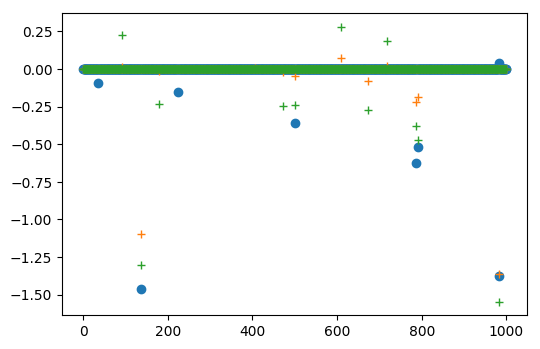

In [13]:
plot_exp(beta_true, beta, beta_two)

### run 10 experiments

In [29]:
import time

In [31]:
t = time.time()

In [34]:
time.time() - t

24.291521072387695

In [ ]:
ratios = []
for i in range(10):
    t = time.time()
    X, y, beta_true = create_experiment(n, p, X_s, beta_s, noise_s, S)
    beta = solve_experiment(X, y, noise_s, t=5)
    beta_two = two_stage_solve(X, beta, noise_s, alpha)
    ratio = error_ratio(beta, beta_true, noise_s)
    print("ratio={} in {} seconds".format(ratio, time.time() - t))
    ratios.append(ratio)

ratio=16.912208446853356 in 260.0478820800781 seconds
ratio=19.43693738911309 in 299.47651505470276 seconds
ratio=17.331328106471535 in 173.46966791152954 seconds


In [ ]:
# X is fixed
# select a support set T of size |T | = S uniformly at random, and sample a vector β on
# T with independent and identically distributed entries accor
# βi = εi(1 + |ai|) where the sign εi = ±1 with probability 1/2, and ai ∼ N(0,1)
# y ̃ = Xβ + z, with z ∼ N(0,σ2 In) and compute βˆ by means of the two-stage procedure
# repeat 500 times for each S